# PCA - KNearest-Neigbors
- This notebook will explore different architectures and hyperparameters of the `KNearest-Neighbors` looking for an optimal configuration. In this case, the Dataset with a PCA dimensionality reduction will be used.
- All data has been previously processed and normalized in the notebook `data_expl_and_preproc.ipynb`.

## Authors
- Izquierdo Alvarez, Mario
- Giménez López, Antonio
- Nuñez Sánchez, Fernando
- Romero Romero, Martín


## Enviroment configuration
- Firstly, the needed packages along with our custom Modules are loaded. Additionally, a `Random.seed()` is set for reproducibility.

In [1]:
using Random
using Statistics
# Including Modules
push!(LOAD_PATH, "../modules")

#Random seed for reproducibility
seed = 42
Random.seed!(seed)

TaskLocalRNG()

In [2]:
using HDF5
using Preprocessing
using ModelSelection
using Plotting
using Sk_Modeling

[ Info: Precompiling Sk_Modeling [top-level]
[ Info: Skipping precompilation since __precompile__(false). Importing Sk_Modeling [top-level].
[ Info: Running `conda install -y -c anaconda conda` in root environment


Solving environment: ...working... done

## Package Plan ##

  environment location: /home/martin/.julia/conda/3/x86_64

  added / updated specs:
    - conda


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2023.11.~ --> anaconda::ca-certificates-2023.08.22-h06a4308_0 
  certifi            conda-forge/noarch::certifi-2023.11.1~ --> anaconda/linux-64::certifi-2023.11.17-py310h06a4308_0 




Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0


[ Info: Running `conda install -y -c conda-forge 'libstdcxx-ng>=3.4,<13.0'` in root environment


Solving environment: ...working... done

## Package Plan ##

  environment location: /home/martin/.julia/conda/3/x86_64

  added / updated specs:
    - libstdcxx-ng[version='>=3.4,<13.0']


The following packages will be UPDATED:

  ca-certificates    anaconda::ca-certificates-2023.08.22-~ --> conda-forge::ca-certificates-2023.11.17-hbcca054_0 

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            anaconda/linux-64::certifi-2023.11.17~ --> conda-forge/noarch::certifi-2023.11.17-pyhd8ed1ab_0 




Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... 



==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0




done


## Loading data
- The dataset used in this notebook has been reduced using PCA dimensionality reduction.

In [3]:
file = h5open("pca_data.h5", "r")
train_input = read(file, "train_input")
train_tags = read(file, "train_tags")
test_input = read(file, "test_input")
test_tags = read(file, "test_tags")
close(file)

## 10-Fold Cross-Validation

The cross-validation technique is applied to get the performance estimation of the different models. 

In this process, we have tested several architectures and iteratively we are discarding the worst ones and making slight variations of the best ones, trying to approximate an optimal configuration.

In [4]:
model = :KNN
# Params for cross validation
N = size(train_input, 1)
k = 10

kFoldIndices = crossvalidation(N,k);
best_models_acc = [];

In [5]:
cov_matrix = cov(train_input, dims=1)
inv_cov_matrix = inv(cov_matrix)
# Define an array of hyperparameter dictionaries for the Decision Tree model
hyperparameters = [
    Dict(:n_neighbors => 10, :weights=> "uniform" ),
    Dict(:n_neighbors => 20, :weights=> "uniform" ),
    Dict(:n_neighbors => 30, :weights=> "uniform" ),
    Dict(:n_neighbors => 10, :weights=> "distance"),
    Dict(:n_neighbors => 20, :weights=> "distance"),
    Dict(:n_neighbors => 30, :weights=> "distance") 
]

# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6

----- acc means -----
Hyperparams set 6 -> 0.488 ± 0.035
Hyperparams set 3 -> 0.479 ± 0.037
Hyperparams set 5 -> 0.464 ± 0.026
Hyperparams set 2 -> 0.459 ± 0.03
Hyperparams set 4 -> 0.414 ± 0.038
Hyperparams set 1 -> 0.408 ± 0.036

----- sensitivity means -----
Hyperparams set 6 -> 0.488 ± 0.035
Hyperparams set 3 -> 0.479 ± 0.037
Hyperparams set 5 -> 0.464 ± 0.026
Hyperparams set 2 -> 0.459 ± 0.03
Hyperparams set 4 -> 0.414 ± 0.038
Hyperparams set 1 -> 0.407 ± 0.036

----- specificity means -----
Hyperparams set 6 -> 0.83 ± 0.013
Hyperparams set 3 -> 0.827 ± 0.014
Hyperparams set 5 -> 0.822 ± 0.015
Hyperparams set 2 -> 0.82 ± 0.016
Hyperparams set 4 -> 0.803 ± 0.01
Hyperparams set 1 -> 0.802 ± 0.013

----- ppv means -----
Hyperparams set 6 -> 0.515 ± 0.03

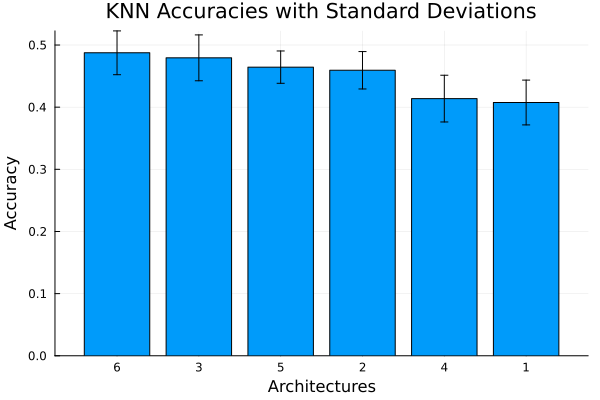

In [6]:
plot_acc_comparison(model, all_metrics)

### Discussion
In this first approach, it seems that the best results are obtained with a greater number of neighbors.


### Testing Entropy criterion

In [7]:
hyperparameters = [
    Dict(:n_neighbors => 30, :weights=> "uniform"),
    Dict(:n_neighbors => 40, :weights=> "uniform"),
    Dict(:n_neighbors => 50, :weights=> "uniform"),
    Dict(:n_neighbors => 30, :weights=> "distance"),
    Dict(:n_neighbors => 40, :weights=> "distance"),
    Dict(:n_neighbors => 50, :weights=> "distance") 
]
# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6

----- acc means -----
Hyperparams set 3 -> 0.511 ± 0.035
Hyperparams set 6 -> 0.508 ± 0.034
Hyperparams set 5 -> 0.5 ± 0.025
Hyperparams set 4 -> 0.488 ± 0.035
Hyperparams set 2 -> 0.486 ± 0.032
Hyperparams set 1 -> 0.479 ± 0.037

----- sensitivity means -----
Hyperparams set 3 -> 0.511 ± 0.035
Hyperparams set 6 -> 0.508 ± 0.034
Hyperparams set 5 -> 0.5 ± 0.025
Hyperparams set 4 -> 0.488 ± 0.035
Hyperparams set 2 -> 0.486 ± 0.032
Hyperparams set 1 -> 0.479 ± 0.037

----- specificity means -----
Hyperparams set 6 -> 0.839 ± 0.009
Hyperparams set 3 -> 0.838 ± 0.01
Hyperparams set 5 -> 0.835 ± 0.01
Hyperparams set 2 -> 0.83 ± 0.014
Hyperparams set 4 -> 0.83 ± 0.013
Hyperparams set 1 -> 0.827 ± 0.014

----- ppv means -----
Hyperparams set 3 -> 0.544 ± 0.022
H

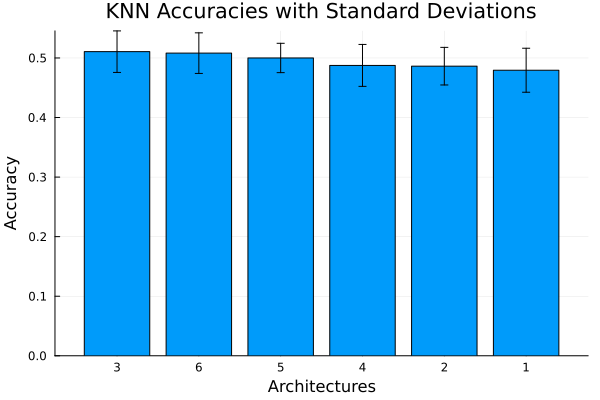

In [8]:
plot_acc_comparison(model, all_metrics)

### Discussion

The value of weights seems not affect to final perfomance, but "uniform" weights seems to have a little better results.

### Increasing neighbors

In [9]:
hyperparameters = [
    Dict(:n_neighbors => 60, :weights=> "uniform"),
    Dict(:n_neighbors => 70, :weights=> "uniform"),
    Dict(:n_neighbors => 80, :weights=> "uniform"),
    Dict(:n_neighbors => 90, :weights=> "uniform"),
    Dict(:n_neighbors => 100, :weights=> "uniform"),
    Dict(:n_neighbors => 110, :weights=> "uniform") 
]
all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6

----- acc means -----
Hyperparams set 5 -> 0.548 ± 0.028
Hyperparams set 6 -> 0.547 ± 0.033
Hyperparams set 4 -> 0.538 ± 0.03
Hyperparams set 2 -> 0.534 ± 0.022
Hyperparams set 3 -> 0.526 ± 0.022
Hyperparams set 1 -> 0.518 ± 0.025

----- sensitivity means -----
Hyperparams set 5 -> 0.548 ± 0.028
Hyperparams set 6 -> 0.547 ± 0.033
Hyperparams set 4 -> 0.538 ± 0.03
Hyperparams set 2 -> 0.534 ± 0.022
Hyperparams set 3 -> 0.526 ± 0.022
Hyperparams set 1 -> 0.518 ± 0.025

----- specificity means -----
Hyperparams set 6 -> 0.852 ± 0.015
Hyperparams set 5 -> 0.852 ± 0.012
Hyperparams set 4 -> 0.848 ± 0.015
Hyperparams set 2 -> 0.847 ± 0.013
Hyperparams set 3 -> 0.844 ± 0.014
Hyperparams set 1 -> 0.841 ± 0.008

----- ppv means -----
Hyperparams set 6 -> 0.6 ± 0.0

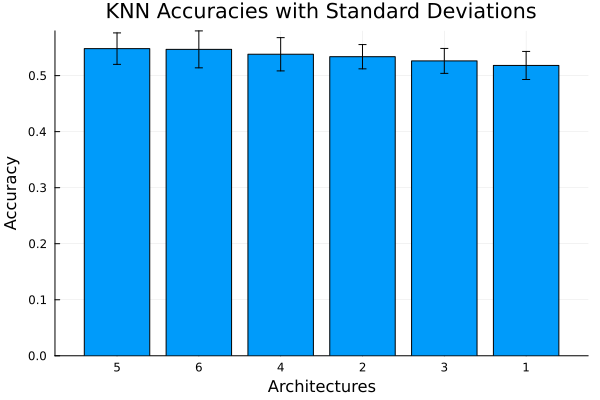

In [10]:
plot_acc_comparison(model, all_metrics)

### Discussion
It seems that among 100 neighbors, it is the value that offers the best results.

### Testing Mahalanobis distance

In [11]:
hyperparameters = [
    Dict(:n_neighbors => 10, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 20, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 50, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 20, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 50, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 100,:metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 110,:metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)) 
 
]
all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6
Training with set of hyperparameters 7

----- acc means -----
Hyperparams set 7 -> 0.671 ± 0.032
Hyperparams set 6 -> 0.665 ± 0.021
Hyperparams set 3 -> 0.66 ± 0.024
Hyperparams set 5 -> 0.66 ± 0.024
Hyperparams set 2 -> 0.601 ± 0.027
Hyperparams set 4 -> 0.601 ± 0.027
Hyperparams set 1 -> 0.539 ± 0.033

----- sensitivity means -----
Hyperparams set 7 -> 0.671 ± 0.032
Hyperparams set 6 -> 0.665 ± 0.021
Hyperparams set 3 -> 0.66 ± 0.024
Hyperparams set 5 -> 0.66 ± 0.024
Hyperparams set 2 -> 0.601 ± 0.027
Hyperparams set 4 -> 0.601 ± 0.027
Hyperparams set 1 -> 0.539 ± 0.033

----- specificity means -----
Hyperparams set 7 -> 0.891 ± 0.011
Hyperparams set 6 -> 0.89 ± 0.007
Hyperparams set 3 -> 0.887 ± 0.007
Hyperparams set 5 -> 0.887 ± 0.007
Hyperparams set 2

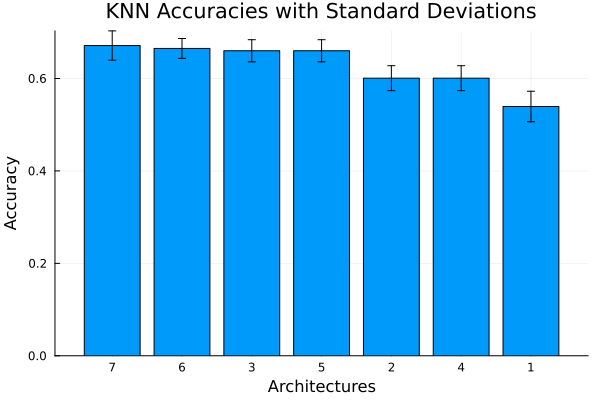

In [12]:
plot_acc_comparison(model, all_metrics)

### Discussion

If we use the mahalanobis distance as metric, the results are better than the previous ones.

## Increasing neigbors with mahalanobis distance



In [13]:
hyperparameters = [
    Dict(:n_neighbors => 120, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 150, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 170, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 200, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 220, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 250,:metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 300,:metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)) 
 
]
all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6
Training with set of hyperparameters 7

----- acc means -----
Hyperparams set 7 -> 0.698 ± 0.031
Hyperparams set 6 -> 0.689 ± 0.031
Hyperparams set 4 -> 0.684 ± 0.043
Hyperparams set 5 -> 0.679 ± 0.039
Hyperparams set 3 -> 0.679 ± 0.043
Hyperparams set 1 -> 0.677 ± 0.038
Hyperparams set 2 -> 0.672 ± 0.035

----- sensitivity means -----
Hyperparams set 7 -> 0.698 ± 0.031
Hyperparams set 6 -> 0.689 ± 0.031
Hyperparams set 4 -> 0.684 ± 0.043
Hyperparams set 5 -> 0.679 ± 0.039
Hyperparams set 3 -> 0.679 ± 0.043
Hyperparams set 1 -> 0.677 ± 0.038
Hyperparams set 2 -> 0.672 ± 0.035

----- specificity means -----
Hyperparams set 7 -> 0.9 ± 0.01
Hyperparams set 6 -> 0.897 ± 0.009
Hyperparams set 4 -> 0.895 ± 0.014
Hyperparams set 3 -> 0.894 ± 0.015
Hyperparams set

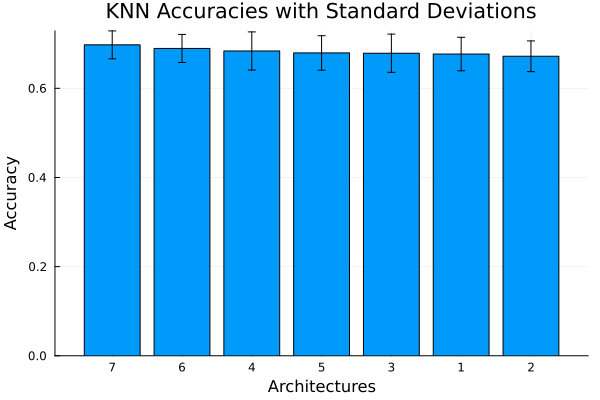

In [14]:
plot_acc_comparison(model, all_metrics)

### Discussion
A higher value of neighbors has the best results

### Increasing neighbors again

In [15]:
hyperparameters = [
    Dict(:n_neighbors => 300, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 320, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 350, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 370, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 400, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 420,:metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),
    Dict(:n_neighbors => 450,:metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)) 
 
]
all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6
Training with set of hyperparameters 7

----- acc means -----
Hyperparams set 5 -> 0.706 ± 0.035
Hyperparams set 6 -> 0.705 ± 0.031
Hyperparams set 7 -> 0.699 ± 0.045
Hyperparams set 4 -> 0.698 ± 0.044
Hyperparams set 1 -> 0.698 ± 0.031
Hyperparams set 2 -> 0.696 ± 0.04
Hyperparams set 3 -> 0.695 ± 0.036

----- sensitivity means -----
Hyperparams set 5 -> 0.706 ± 0.035
Hyperparams set 6 -> 0.705 ± 0.031
Hyperparams set 7 -> 0.699 ± 0.045
Hyperparams set 4 -> 0.698 ± 0.044
Hyperparams set 1 -> 0.698 ± 0.031
Hyperparams set 2 -> 0.696 ± 0.04
Hyperparams set 3 -> 0.695 ± 0.036

----- specificity means -----
Hyperparams set 5 -> 0.904 ± 0.011
Hyperparams set 6 -> 0.903 ± 0.009
Hyperparams set 7 -> 0.902 ± 0.013
Hyperparams set 4 -> 0.901 ± 0.014
Hyperparams se

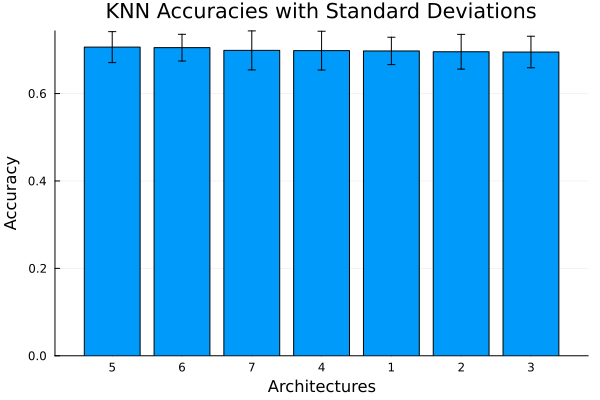

In [16]:
plot_acc_comparison(model, all_metrics)

### Discussion

It seems that 400 neighbors offers the best results

### Final Model

In [17]:
hyperparameters = [
    Dict(:n_neighbors => 400, :metric => "mahalanobis", :weights=> "distance",:metric_params => Dict("VI"=>inv_cov_matrix)),

 
]
all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices);

Training with set of hyperparameters 1

----- acc means -----
Hyperparams set 1 -> 0.706 ± 0.035

----- sensitivity means -----
Hyperparams set 1 -> 0.706 ± 0.035

----- specificity means -----
Hyperparams set 1 -> 0.904 ± 0.011

----- ppv means -----
Hyperparams set 1 -> 0.741 ± 0.024

----- npv means -----
Hyperparams set 1 -> 0.898 ± 0.012

----- f_score means -----
Hyperparams set 1 -> 0.713 ± 0.032

----- err_rate -----
Hyperparams set 1 -> 0.294 ± 0.035


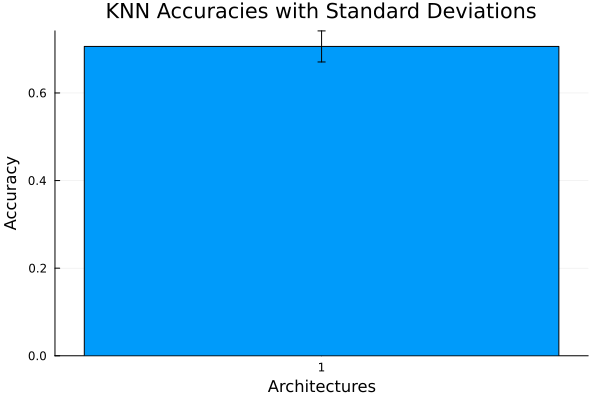

In [18]:
plot_acc_comparison(model, all_metrics)

## Final discussion

Finally, as can be seen in the graph below, the results obtained in the last experiments are better than the first experiments. The model with a higher accuracy score has the following hyperparameters:

    1. n_neighbors=400
    2. metric: mahalanobis
    3. weights: distance

All of this results in an accuracy of **0.706 ± 0.035**.

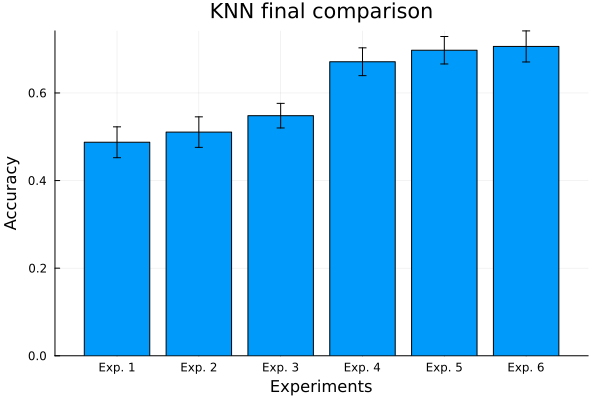

In [20]:
plot_final_comparison("KNN final comparison", best_models_acc)